# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev2 toc-item"><a href="#Parse-input" data-toc-modified-id="Parse-input-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parse input</a></div><div class="lev1 toc-item"><a href="#Overview-visualization" data-toc-modified-id="Overview-visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overview visualization</a></div><div class="lev1 toc-item"><a href="#Differential-expression" data-toc-modified-id="Differential-expression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Differential expression</a></div><div class="lev2 toc-item"><a href="#Without-batch-correction" data-toc-modified-id="Without-batch-correction-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Without batch correction</a></div><div class="lev2 toc-item"><a href="#With-batch-correction" data-toc-modified-id="With-batch-correction-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>With batch correction</a></div><div class="lev1 toc-item"><a href="#Summarize-results" data-toc-modified-id="Summarize-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summarize results</a></div><div class="lev1 toc-item"><a href="#Run-ComBat-to-adjust" data-toc-modified-id="Run-ComBat-to-adjust-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run ComBat to adjust</a></div><div class="lev2 toc-item"><a href="#ComBat-modelling-condition" data-toc-modified-id="ComBat-modelling-condition-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>ComBat modelling condition</a></div><div class="lev3 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-511"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Statistics</a></div><div class="lev2 toc-item"><a href="#ComBat-not-modelling-biological-factor" data-toc-modified-id="ComBat-not-modelling-biological-factor-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>ComBat not modelling biological factor</a></div><div class="lev3 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-521"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Statistics</a></div>

# Setup

In [1]:
run <- "batch13_batch_effect_3"
expression_fp <- paste0(run, "/full_quant.tsv")
design_fp <- paste0(run, "/design.tsv")

In [2]:
library(ggplot2)
library(ggfortify)
library(ggdendro)
library(limma)
library(gridExtra)

source("~/src/JupyterRReuse/proteomics_multivariate_vis.R")
source("~/src/JupyterRReuse/visualization_utils.R")
source("~/src/JupyterRReuse/proteomics_stats.R")

In [3]:
plot_pca <- function(data_m, design_m, pc1, pc2, color_factor, colors, custom_names, legend=T, title_app="", cont_scale=F) {
    
    if (!cont_scale) {
        getPalette <- colorRampPalette(RColorBrewer::brewer.pal(9, "Set1"))        
    }
    title <- paste0("PCA, PC", pc1, " vs PC", pc2, " ", title_app)
    plt <- make_expression_pca(data_m, design_m, color_factor=color_factor, title=title, 
                               pca_axis1=pc1, pca_axis2=pc2, show_labels=T,
                               only_text=T, color_text=T, custom_names=custom_names)
    if (!cont_scale) {
        plt <- plt + scale_color_manual(values=getPalette(colors))        
    }
    
    if (!legend) {
        plt <- plt + theme(legend.position="none")
    }
    
    plt
}

## Parse input

In [4]:
design_df <- read.csv(design_fp, sep="\t")
design_df$sample <- design_df$name
design_df$batch <- as.factor(design_df$batch)
print(design_df)

   name biorepgroup techrepgroup condition batch sample
1    a1           1            1         a     1     a1
2    a2           2            1         a     1     a2
3    a3           3            1         a     1     a3
4    a4           4            1         a     2     a4
5    a5           5            1         a     2     a5
6    a6           6            1         a     2     a6
7    b1           1            1         b     1     b1
8    b2           2            1         b     1     b2
9    b3           3            1         b     1     b3
10   b4           4            1         b     2     b4
11   b5           5            1         b     2     b5
12   b6           6            1         b     2     b6


In [5]:
raw_data_df <- read.csv(expression_fp, sep="\t")
head(raw_data_df)
raw_data_df$peptide <- as.character(raw_data_df$peptide)
raw_data_df$protein <- as.character(raw_data_df$protein)
data_df <- log2(raw_data_df[, as.character(design_df$name)])
head(data_df)

peptide,protein,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
FCR,sp|P0A7T7|RS18_ECOLI,214896700,121931796,184321500,271512496,241059392,296788592,100823300,151455600,191659200,163611500,192877400,160303300
LCR,sp|Q9JMR4|YUBK_ECOLI,71119800,78468000,59310300,71907200,93951696,75843696,33450600,55569400,40532900,73781504,76170096,65023200
FCQR,sp|P39357|YJHF_ECOLI,99688900,180319792,118280200,201506608,204652500,194317692,71257500,85543900,77426300,195878400,238075708,238782992
KFCR,sp|P0A7T7|RS18_ECOLI,71092550,40633220,62788760,98883100,85249896,91656596,33382840,51384330,66699280,109583604,124100500,108860300
AFVLR,sp|P0ADY1|PPID_ECOLI,117921600,100272400,101190500,207789492,199107592,160638900,120884304,101561100,103980500,166654700,226772800,173452000
GFVLR,sp|P33650|FEOB_ECOLI,138127400,141643300,123001796,139119700,178940100,142594800,54310140,76674700,81098600,156470900,168661300,155923400


a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
27.67907,26.86150,27.45765,28.01644,27.84481,28.14486,26.58725,27.17432,27.51397,27.28570,27.52311,27.25623
26.08375,26.22560,25.82178,26.09963,26.48542,26.17653,24.99553,25.72779,25.27259,26.13676,26.18272,25.95445
26.57093,27.42598,26.81763,27.58625,27.60860,27.53384,26.08654,26.35016,26.20632,27.54538,27.82685,27.83112
26.08320,25.27616,25.90400,26.55922,26.34519,26.44974,24.99260,25.61483,25.99117,26.70746,26.88693,26.69790
26.81325,26.57935,26.59250,27.63055,27.56897,27.25925,26.84905,26.59777,26.63174,27.31229,27.75667,27.36996
27.04142,27.07769,26.87410,27.05175,27.41490,27.08735,25.69472,26.19225,26.27317,27.22132,27.32955,27.21626


In [6]:
head(raw_data_df, 20)

peptide,protein,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
FCR,sp|P0A7T7|RS18_ECOLI,214896700,121931796,184321500,271512496,241059392,296788592,100823300,151455600,191659200,163611500,192877400,160303300
LCR,sp|Q9JMR4|YUBK_ECOLI,71119800,78468000,59310300,71907200,93951696,75843696,33450600,55569400,40532900,73781504,76170096,65023200
FCQR,sp|P39357|YJHF_ECOLI,99688900,180319792,118280200,201506608,204652500,194317692,71257500,85543900,77426300,195878400,238075708,238782992
KFCR,sp|P0A7T7|RS18_ECOLI,71092550,40633220,62788760,98883100,85249896,91656596,33382840,51384330,66699280,109583604,124100500,108860300
AFVLR,sp|P0ADY1|PPID_ECOLI,117921600,100272400,101190500,207789492,199107592,160638900,120884304,101561100,103980500,166654700,226772800,173452000
GFVLR,sp|P33650|FEOB_ECOLI,138127400,141643300,123001796,139119700,178940100,142594800,54310140,76674700,81098600,156470900,168661300,155923400
GWPYA,sp|P58516|SPI3_SOLTU,59262100,75595000,64007500,106385000,106385000,98659800,96264496,103334000,114977000,170528992,153864000,152951008
MTLFR,sp|P77607|YAGL_ECOLI,103958400,113598396,67585100,152633200,150801300,125450600,76624600,62451890,81647104,161134908,196864700,124669300
EFMFYR,sp|P37829|SCRK_SOLTU,96254100,90771704,83931686,142368300,136183000,140118900,137856200,180655408,171385800,193000392,190607800,184908100
FVPLVK,sp|P0A7A5|PIMT_ECOLI,106299900,123949600,105583804,211987100,173504792,138393200,80963496,87531404,115920300,188475800,189569500,182228192


In [7]:
parse_annot <- function(annot_string) {
    
    fields <- unlist(strsplit(as.character(annot_string), "/"))
    annot <- sapply(fields, function(field) { unlist(strsplit(field, "_"))[[2]] })
    
    if (annot == "SOLTU") {
        TRUE
    }
    else if (annot == "ECOLI") {
        FALSE
    }
    else {
        stop(paste0("Unknown annotation: ", annot))
    }
}

In [8]:
spike_col <- sapply(as.character(raw_data_df[, "protein"]), parse_annot)
head(spike_col)


sp|P0A7T7|RS18_ECOLI sp|Q9JMR4|YUBK_ECOLI sp|P39357|YJHF_ECOLI 
               FALSE                FALSE                FALSE 
sp|P0A7T7|RS18_ECOLI sp|P0ADY1|PPID_ECOLI sp|P33650|FEOB_ECOLI 
               FALSE                FALSE                FALSE

# Overview visualization

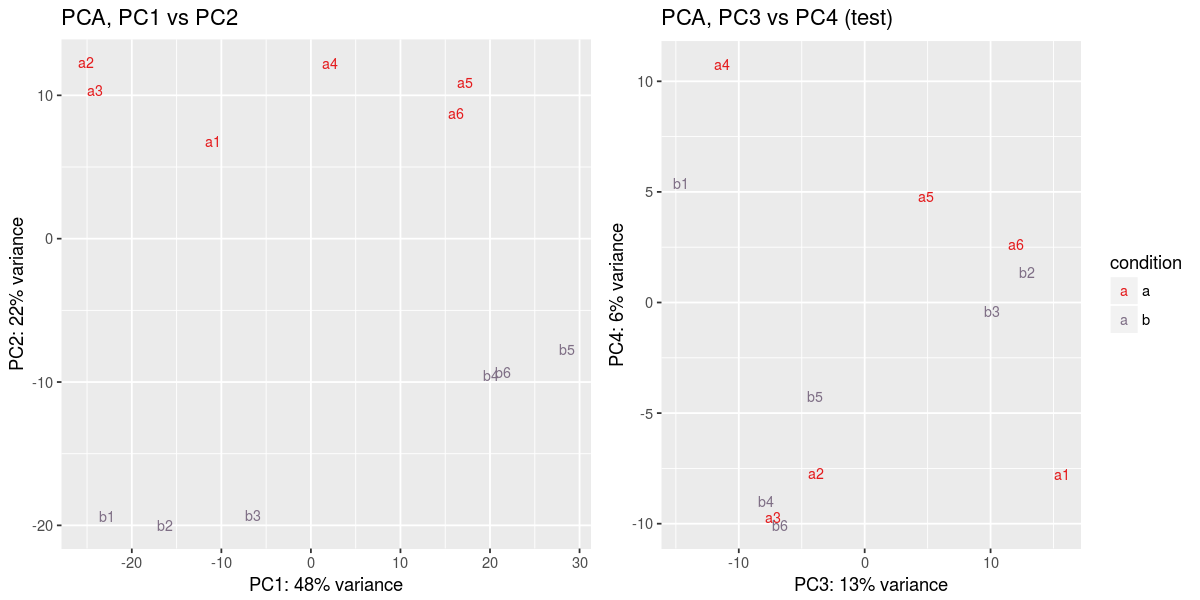

In [9]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "condition", colors=4, custom_names=design_df$name, legend=F)
p1_2 <- plot_pca(data_df, design_df, 3, 4, "condition", colors=4, custom_names=design_df$name, legend=T, title_app="(test)")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


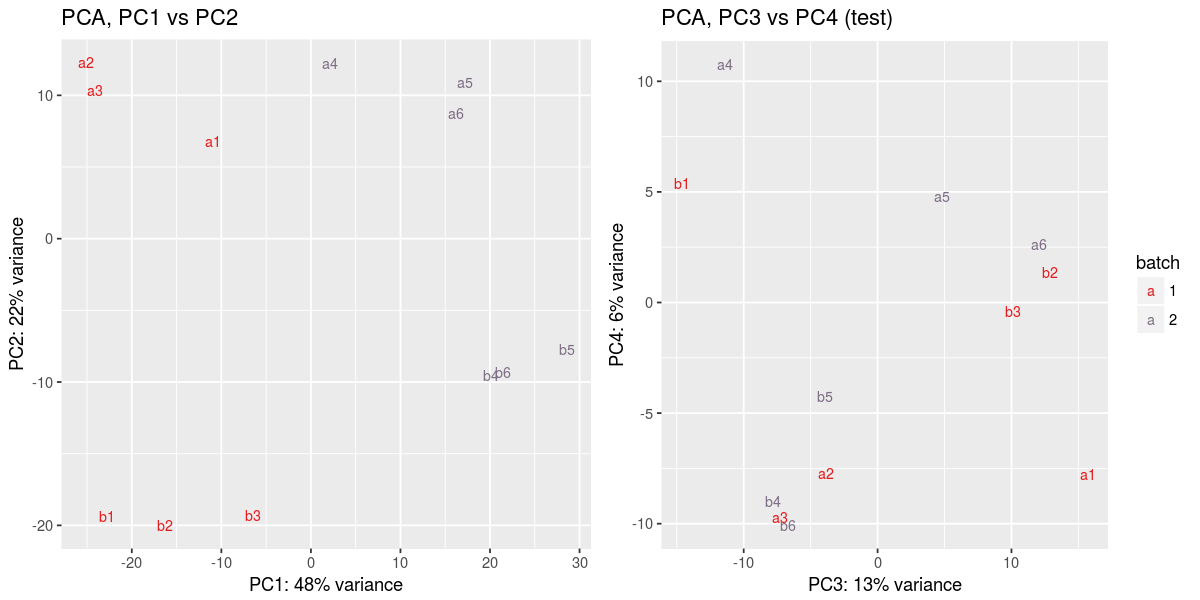

In [10]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F)
p1_2 <- plot_pca(data_df, design_df, 3, 4, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="(test)")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


# Differential expression

In [11]:
calculate_anova <- function(row, cond, batch=NULL) {
    
    if (!is.null(batch)) {
        print8
        anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond, Batch=batch))        
        av <- aov(Intensity~Cond+Batch, anova_df)        
    }
    else {
        anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond))
        av <- aov(Intensity~Cond, anova_df)                
    }
    
    av_summary <- summary(av)
    p_val <- av_summary[[1]]["Cond", "Pr(>F)"]
    p_val
}

In [12]:
get_truth_vector <- function(measured_pos_vect, actually_pos_vect) {
    
    truth_vector <- c()
    
    for (i in 1:length(measured_pos_vect)) {
        
        measured_pos <- measured_pos_vect[i]
        actually_pos <- actually_pos_vect[i]
        
        if (measured_pos && actually_pos) {
            outcome <- "TP"
        }
        else if (!measured_pos && !actually_pos) {
            outcome <- "TN"
        }
        else if (measured_pos && !actually_pos) {
            outcome <- "FP"
        }
        else if (!measured_pos && actually_pos) {
            outcome <- "FN"
        }
        else {
            stop(paste("Unknown state, measured_pos:", measured_pos, 
                       ", actually_pos:", actually_pos))
        }
        
        truth_vector <- c(truth_vector, outcome)
    }
    
    truth_vector
}

print_truth_summary <- function(truth_vector) {
    
    truth_table <- table(truth_vector)
    print(truth_table)
    
    FN <- truth_table["FN"]
    FP <- truth_table["FP"]
    TN <- truth_table["TN"]
    TP <- truth_table["TP"]
    
    specificity <- TP / (TP + FP)
    recall <- TP / (TP + FN)
    
    print(paste("Specificity:", specificity))
    print(paste("Recall:", recall))
}

## Without batch correction

In [13]:
print("Without batch correction")

p_vals <- unlist(apply(data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)

[1] "Without batch correction"
[1] "P-vals below 0.1: 275"
[1] "Spike-in count: 138"
[1] "Passing FDR threshold: 171"
truth_vector
 FN  FP  TN  TP 
 20  53 639 118 
[1] "Specificity: 0.690058479532164"
[1] "Recall: 0.855072463768116"


## With batch correction

In [14]:
print("With batch correction")

p_vals <- unlist(apply(data_df, 1, calculate_anova, cond=design_df$condition, batch=design_df$batch))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)

[1] "With batch correction"
[1] "P-vals below 0.1: 386"
[1] "Spike-in count: 138"
[1] "Passing FDR threshold: 306"
truth_vector
 FN  FP  TN  TP 
  6 174 518 132 
[1] "Specificity: 0.431372549019608"
[1] "Recall: 0.956521739130435"


# Summarize results

In [15]:
final_df <- data.frame(peptide=raw_data_df[,"peptide"], 
                  protein=raw_data_df[,"protein"], 
                  spike_col=spike_col, 
                  p_val=p_vals, 
                  q_val=q_vals)


In [16]:
head(final_df)

peptide,protein,spike_col,p_val,q_val
FCR,sp|P0A7T7|RS18_ECOLI,FALSE,0.04727012,0.12035030
LCR,sp|Q9JMR4|YUBK_ECOLI,FALSE,0.02350876,0.06786208
FCQR,sp|P39357|YJHF_ECOLI,FALSE,0.18767802,0.33673378
KFCR,sp|P0A7T7|RS18_ECOLI,FALSE,0.82854029,0.90604538
AFVLR,sp|P0ADY1|PPID_ECOLI,FALSE,0.90482956,0.95184859
GFVLR,sp|P33650|FEOB_ECOLI,FALSE,0.05700420,0.14208254


In [17]:
tail(final_df)

,peptide,protein,spike_col,p_val,q_val
825,IPNLLVNGSSGIAVGMATNIPPHNLTEVINGCLAYIDDEDISIEGLMEHIPGPDFPTAAIINGRR,sp|P0AES4|GYRA_ECOLI,FALSE,0.74688338,0.85270042
826,GYVANSVWTVTAVSGDSVTLSDGQQTREIRPGQEQAEQHIDLAYAITAHGAQGASETFAIALEGTEGNR,sp|P14565|TRAI1_ECOLI,FALSE,0.73065369,0.84301513
827,IPDVMPTKIPNLLVNGSSGIAVGMATNIPPHNLTEVINGCLAYIDDEDISIEGLMEHIPGPDFPTAAIINGR,sp|P0AES4|GYRA_ECOLI,FALSE,0.42348978,0.59676828
828,VITPVFKPIGVHEDNWQATVGLFTGAMAKEVVVGTLNTLYTAENIQDEEFNPAEFNLGEELFSAIDETWQSLK,sp|P33650|FEOB_ECOLI,FALSE,0.01796264,0.05521850
829,YPVTLTPAPEGGYMVSFVDIPEALTQGETVAEAMEAAKDALLTAFDFYFEDNELIPLPSPLNSHDHFIEVPLSVASK,sp|P67697|HICB_ECOLI,FALSE,0.18233141,0.33281006
830,QVLIDSGVGQYISTLVSGMDINPILMAWGVAAFLRICLGSATVAAISTAGLVIPLLAVHPNTNLALITLATGAGSCICSHVNDASFWMIK,sp|P39357|YJHF_ECOLI,FALSE,0.03296355,0.09089617


In [18]:
head(final_df[final_df[, "q_val"] < 0.1, ])

,peptide,protein,spike_col,p_val,q_val
2,LCR,sp|Q9JMR4|YUBK_ECOLI,FALSE,2.350876e-02,0.0678620758
7,GWPYA,sp|P58516|SPI3_SOLTU,TRUE,5.553014e-06,0.0001197045
9,EFMFYR,sp|P37829|SCRK_SOLTU,TRUE,6.767655e-05,0.0005912793
11,LLVDLK,sp|P0ADY1|PPID_ECOLI,FALSE,1.278748e-02,0.0435767964
12,LMEVIR,sp|P0AES4|GYRA_ECOLI,FALSE,1.634980e-02,0.0521935903
17,AFDLMLK,sp|P14674|ADH2_SOLTU,TRUE,4.038371e-04,0.0025013790


# Run ComBat to adjust

In [19]:
library(sva)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-22. For overview type 'help("mgcv-package")'.
Loading required package: genefilter


## ComBat modelling condition

In [20]:
modcombat <- model.matrix(~1+condition, data=design_df)
modcombat

,(Intercept),conditionb
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,1
8,1,1
9,1,1
10,1,1


Found 2 batches
Adjusting for 1 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


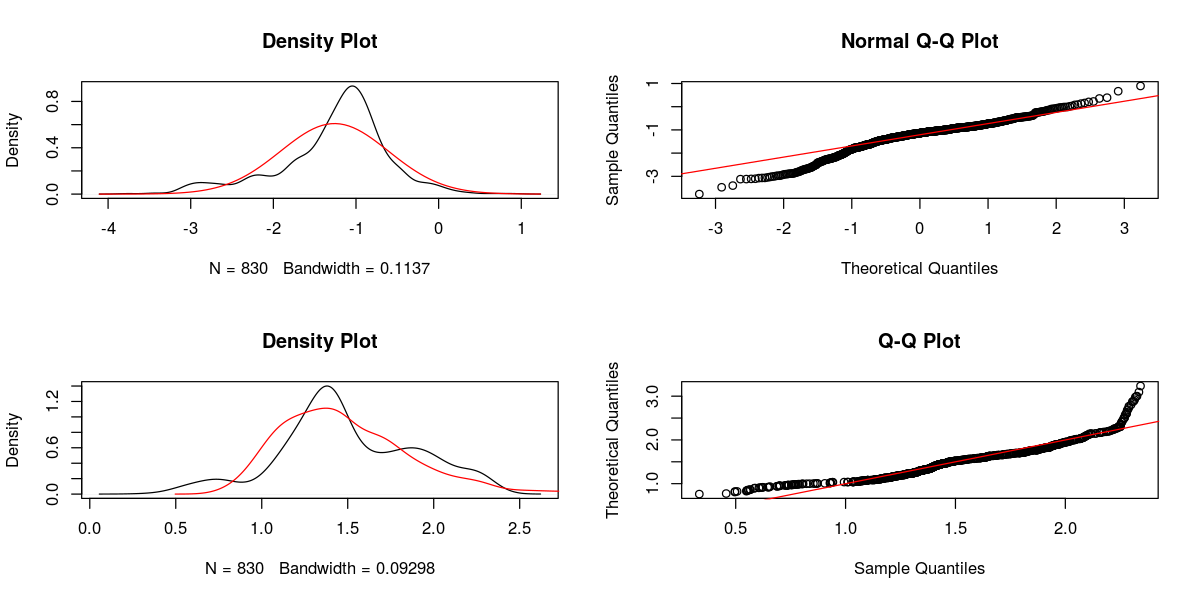

In [21]:
combat_data_df <- ComBat(dat=data_df, batch=design_df$batch, mod=modcombat, par.prior=TRUE, prior.plots=TRUE)

In [22]:
head(combat_data_df)

a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
27.90478,27.24508,27.72612,27.77127,27.56731,27.92387,26.93807,27.41177,27.68584,26.98651,27.26863,26.95149
26.31312,26.42992,26.09741,25.81071,26.23653,25.89559,25.33987,25.94282,25.56800,25.89705,25.94779,25.69583
27.08712,27.79022,27.28998,27.06993,27.09449,27.01233,26.63856,26.85533,26.73705,27.05301,27.36234,27.36704
26.44683,25.79601,26.30232,26.09658,25.84036,25.96551,25.57617,26.07794,26.38144,26.26506,26.47992,26.25362
27.13123,26.93219,26.94338,27.27909,27.22165,26.93272,27.16352,26.94969,26.97860,26.98303,27.39757,27.03683
27.34873,27.37899,27.20910,26.67394,27.05782,26.71157,26.15263,26.56782,26.63535,26.87811,26.99252,26.87276


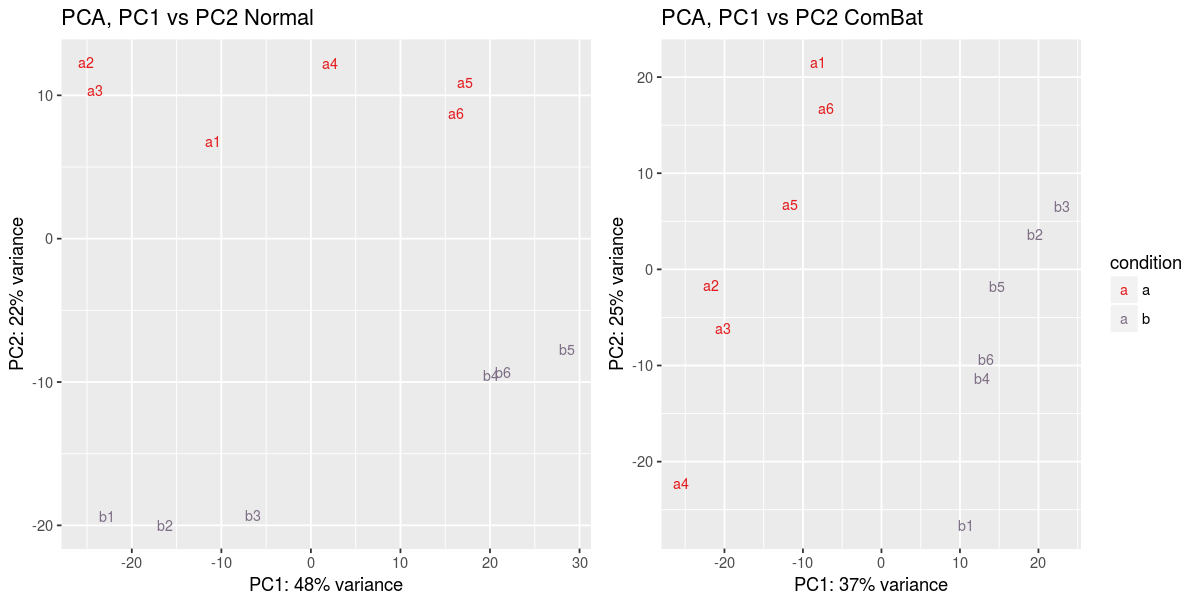

In [23]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "condition", colors=4, custom_names=design_df$name, legend=F, title_app = "Normal")
p1_2 <- plot_pca(combat_data_df, design_df, 1, 2, "condition", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


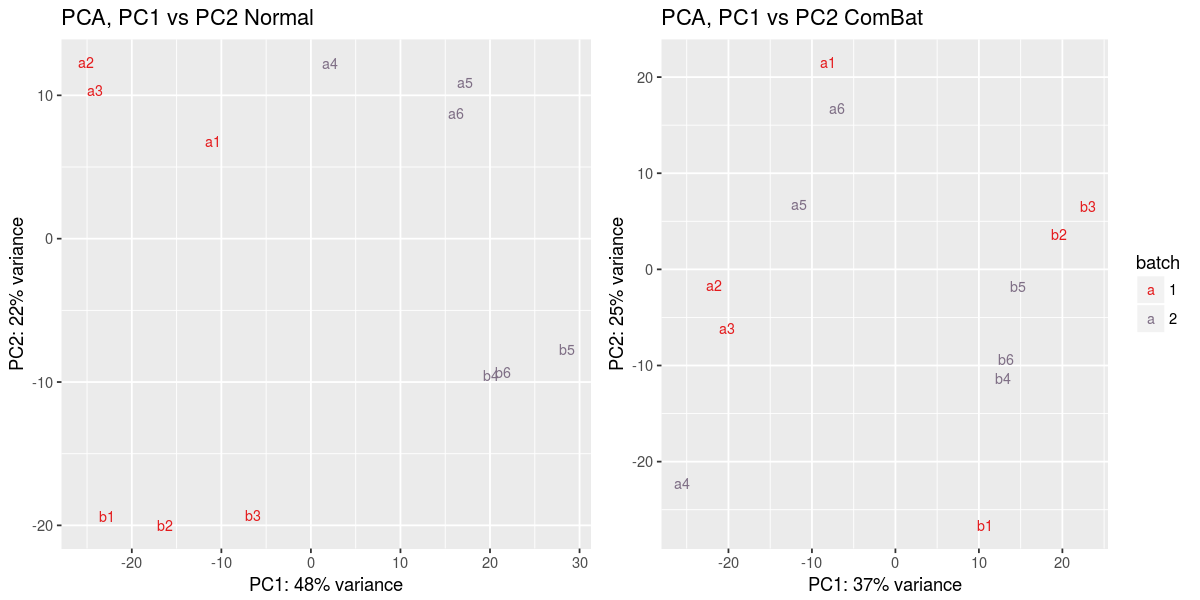

In [24]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F, title_app="Normal")
p1_2 <- plot_pca(combat_data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


### Statistics

In [25]:
print("ComBat statistics")

p_vals <- unlist(apply(combat_data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)

[1] "ComBat statistics"
[1] "P-vals below 0.1: 424"
[1] "Spike-in count: 138"
[1] "Passing FDR threshold: 351"
truth_vector
 FN  FP  TN  TP 
  6 219 473 132 
[1] "Specificity: 0.376068376068376"
[1] "Recall: 0.956521739130435"


## ComBat not modelling biological factor

In [26]:
modcombat <- model.matrix(~1, data=design_df)
head(modcombat)

,(Intercept)
1,1
2,1
3,1
4,1
5,1
6,1


Found 2 batches
Adjusting for 0 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


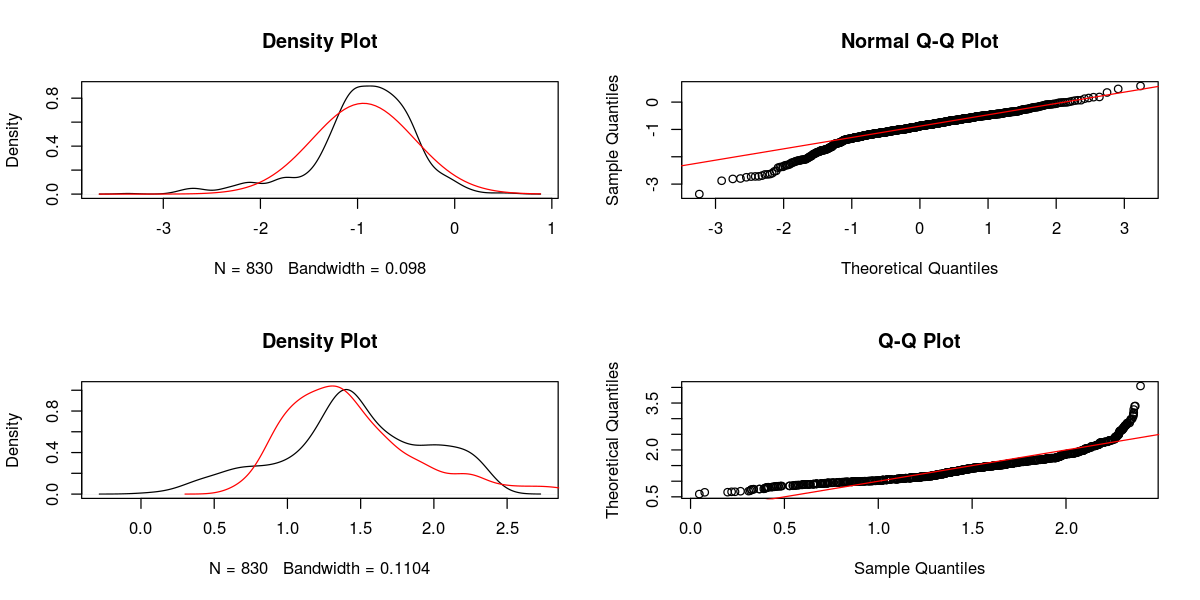

In [27]:
only_int_combat_data_df <- ComBat(dat=data_df, batch=design_df$batch, mod=modcombat, par.prior=TRUE, prior.plots=TRUE)

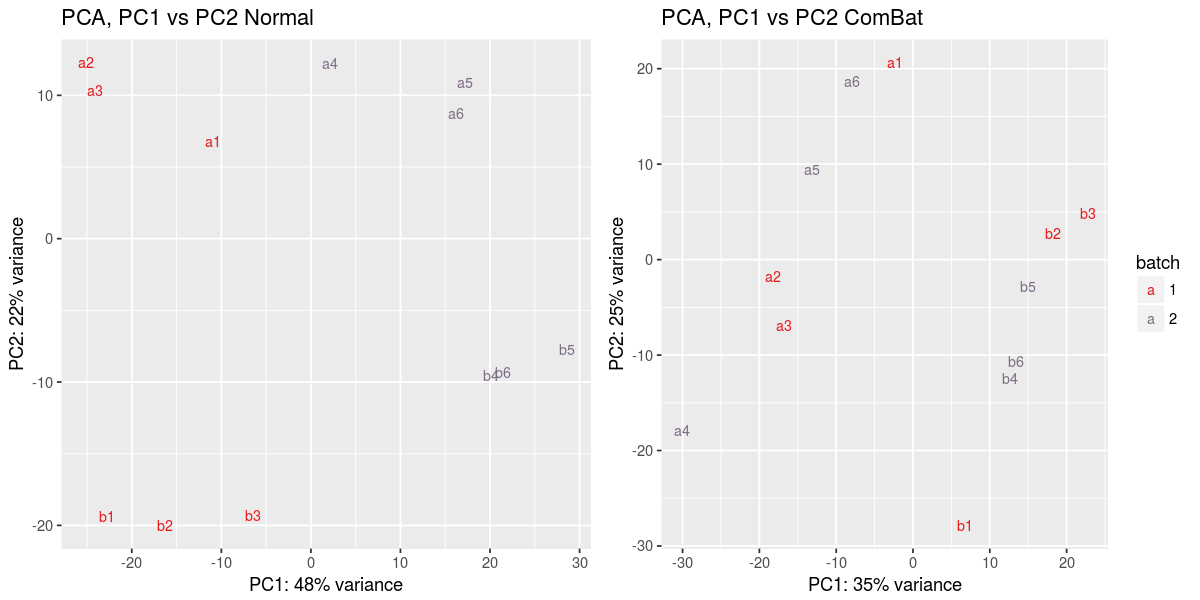

In [28]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F, title_app = "Normal")
p1_2 <- plot_pca(only_int_combat_data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


### Statistics

In [29]:
print("ComBat statistics (only intercept)")

p_vals <- unlist(apply(only_int_combat_data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)

[1] "ComBat statistics (only intercept)"
[1] "P-vals below 0.1: 396"
[1] "Spike-in count: 138"
[1] "Passing FDR threshold: 323"
truth_vector
 FN  FP  TN  TP 
  6 191 501 132 
[1] "Specificity: 0.408668730650155"
[1] "Recall: 0.956521739130435"
